In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer,confusion_matrix,ConfusionMatrixDisplay

import xgboost as xgb
import lightgbm as lgb

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC



from sklearn.preprocessing import StandardScaler, RobustScaler

from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters # fait tout lagger
from tsfresh.feature_extraction import MinimalFCParameters # aussi
import time

from sklearn.decomposition import PCA


# Retour au preprocessing pour les times series pour éviter tout data leakage
- dataset1 découpage train_tot <= 2011/test > 2011 | <font color='green'>Ok</font>
- découpage train/validation : train<=2001 / 2001<validation <=2011 | <font color='green'>Ok</font>
- décalage de la targer (war) | <font color='green'>Ok</font>
- interpolation train et test independemment | <font color='green'>Ok</font>
- scaling current LCU |  <font color='green'>OK pas besoin pour dataset 2 (pas de current LCU)</font>
- fit RobustScaler sur dataset 2 sur train, puis transform sur train et test  | <font color='green'>Ok</font>
- rolling window à l'aide de tsfresh | <font color='red'>trop long et trop gourmand</font>
- creation feature lag avec pandas |  <font color='green'>Ok</font>
- fait PCA sur train, puis transform sur train et test   <font color='green'>Ok</font>
- potentiel problème dans le découpage car on coupe les séries temporelles, il faudrait séparer sur les pays - a mettre dans les limitation


In [146]:
dataset1 = pd.read_csv('dataset1_predictNextYear.csv') 

dataset1.drop(columns=("Unnamed: 0"),inplace=True)

## Suppression des features avec plus de 25% de missing values pour au moins un pays + ajout de flag: was_interpolated

In [147]:
indicator_cols = dataset1.columns.difference(['REF_AREA', 'TIME_PERIOD','war'])


#matrice des valeurs manquantes par pays et indicateur

missing_matrix = (
    dataset1.groupby('REF_AREA')[indicator_cols]
    .apply(lambda g: g.isna().mean())
)
# On supprime les indicateurs avec trop de valeurs manquantes par pays 
# Res : 83 -> pas trop mal
missingMatrix2 = missing_matrix.copy()
for i in missingMatrix2.columns:
    if missingMatrix2[i].max()>0.25:
        missingMatrix2.drop(i,axis=1,inplace=True)


### Code pour ne garder que les colonnes présentes dans missingMatrix2

colKeep = [ "REF_AREA","TIME_PERIOD", "war"]

cols_to_keep = list(missingMatrix2.columns) + colKeep
cols_to_keep = list(dict.fromkeys(cols_to_keep))  

dataset1 = dataset1[cols_to_keep]




In [148]:
### DATAFRAME AVEC INDICATEURS + FLAG : was_interpolated

df_flagInterpolated = dataset1.copy()
cols = [c for c in df_flagInterpolated.columns if c not in ['REF_AREA', 'TIME_PERIOD', 'war']]

for i in cols:
    df_flagInterpolated[f"{i}_was_interpolated"] = dataset1[i].isna()

dataset1 = df_flagInterpolated

# On remet REF_AREA et TIME_PERIOD en début de dataframe
cols = ["REF_AREA", "TIME_PERIOD"]  
new_order = cols + [c for c in dataset1.columns if c not in cols]

dataset1 = dataset1[new_order]


In [149]:
# conversion du flag en int

## On repasse le type des colonnes 'was_interpolated' en int au lieu de bool

cols_to_convert = [
    c for c in dataset1.columns 
    if "_was_interpolated" in c
]

for col in cols_to_convert:
    dataset1[col] = dataset1[col].astype(int)

## Split train test

In [150]:
dfPreprocess = dataset1.copy()

features = dfPreprocess.columns.tolist()




test = dfPreprocess[dfPreprocess['TIME_PERIOD']>2011]
train_tot  = dfPreprocess[dfPreprocess['TIME_PERIOD']<=2011] # jeu de train+validation 
train = train_tot[train_tot['TIME_PERIOD']<=2001] # jeu de train uniquement pour la validation
validation  = train_tot[train_tot['TIME_PERIOD']>2001] # jeu de validation


dataset1.shape


(7345, 169)

## on doit décaler de -1 la variable à prédire y (war)
- pourquoi ? : les indicateurs pour un pays/année sont récupérés en fin d'année et résume l'année qui vient d'avoir lieu donc prédire l'état de conflit avec ces indicateurs pour cette même année ne fait pas trop sens. On va donc prédire pour les indicateurs à l'année t, le conflit pour l'année t+1
- pour éviter tout data leakage, nous avons du faire attention à d'abord split le dataset en train/test et seulement après décaler war

In [151]:

def shiftWar(df):
    """
    décale la variable cible (war) de 1 en arrière
    la ligne pour un pays k et une année n va avoir comme variable cible war mais pour l'année n+1

    Returns:
        shifted (pd.Dataframe) : corréspond au df d'entrée avec la variable cible décalé de 1 (changement de nom de la variable cible : war_nextYear)
    """
    df_shifted = []
    for country, group in df.groupby("REF_AREA"):
        g = group.copy()  # correspond au sous-dataframe de chaque pays
        g['war_nextYear'] = g['war'].shift(-1)# décaler les valeurs de war de 1 en arrière
        g = g[:-1]  # supprimer dernière année qui n'a pas de target
        df_shifted.append(g)
    shifted = pd.concat(df_shifted, ignore_index=True)
    shifted["war_nextYear"]  = shifted['war_nextYear'].astype(int) # remettre la valeur de war_nextYear en entier
    return shifted


train = shiftWar(train)
train_tot = shiftWar(train_tot)
test = shiftWar(test)
validation = shiftWar(validation)


In [152]:
train_tot.shape

(5763, 170)

## Filtrage LCU etc (non necessaire pour le dataset dense)

In [58]:
## On refait le filtrage des current LCU (monnais locale) pour faire l'interpolation qu'après le split 
'''

correspondanceIndicateur = pd.read_csv('correspondance_indicateurs.csv')
correspondanceIndicateurFiltre = correspondanceIndicateur[
    correspondanceIndicateur['id'].isin(dataset1.columns)
]

# Filtre les indicateurs en  current LCU

def FilterIndicatorLCU(correspondanceIndicateurFiltre):
    lcu_df = correspondanceIndicateurFiltre[
        correspondanceIndicateurFiltre['label'].str.contains('current LCU|constant LCU', case=False, na=False)
    ]
    
    
    # Ici on vérifie si les indicateurs en LCU ont une version en dollars, constant dollars ou en % du PIB
    correspondances = []
    for _, row in lcu_df.iterrows():
        label = row['label']
        id_ = row['id']
    
        in_usd = correspondanceIndicateurFiltre[
            correspondanceIndicateurFiltre['label'].str.contains('current US', case=False, na=False)
            & correspondanceIndicateurFiltre['label'].str.contains(label.split('(')[0].strip().split(',')[0], case=False, na=False)
        ]
    
        in_constant_usd = correspondanceIndicateurFiltre[
            correspondanceIndicateurFiltre['label'].str.contains('constant 2015 US', case=False, na=False)
            & correspondanceIndicateurFiltre['label'].str.contains(label.split('(')[0].strip().split(',')[0], case=False, na=False)
        ]
    
        in_gdp = correspondanceIndicateurFiltre[
            correspondanceIndicateurFiltre['label'].str.contains('% of GDP', case=False, na=False)
            & correspondanceIndicateurFiltre['label'].str.contains(label.split('(')[0].strip().split(',')[0], case=False, na=False)
        ]
    
        correspondances.append({
            'id': id_,
            'label': label,
            'has_usd': not in_usd.empty,
            'has_constant_usd': not in_constant_usd.empty,
            'has_gdp_percent': not in_gdp.empty
        })
    
    correspondance_df = pd.DataFrame(correspondances)
    df_filtre = correspondance_df[
        (correspondance_df['has_usd'] == False) & 
        (correspondance_df['has_constant_usd'] == False)
    ]
    return correspondance_df
correspondance_df = FilterIndicatorLCU(correspondanceIndicateurFiltre)
IndicateurAsupp = correspondance_df[(correspondance_df['has_usd']==True) | (correspondance_df['has_constant_usd']==True) | (correspondance_df['has_gdp_percent']==True)]
print(IndicateurAsupp.shape)
IndicateurAGarder = correspondance_df[(correspondance_df['has_usd']==False) & (correspondance_df['has_constant_usd']==False) & (correspondance_df['has_gdp_percent']==False)]
print(IndicateurAGarder.head())


### On a les indicateur à scaler par pays car aucun rapport entre eux en fonction de l'unité
[c for c in IndicateurAGarder['id']]
d = dfPreprocess.groupby('REF_AREA')
d.head()
'''

"\n\ncorrespondanceIndicateur = pd.read_csv('correspondance_indicateurs.csv')\ncorrespondanceIndicateurFiltre = correspondanceIndicateur[\n    correspondanceIndicateur['id'].isin(dataset1.columns)\n]\n\n# Filtre les indicateurs en  current LCU\n\ndef FilterIndicatorLCU(correspondanceIndicateurFiltre):\n    lcu_df = correspondanceIndicateurFiltre[\n        correspondanceIndicateurFiltre['label'].str.contains('current LCU|constant LCU', case=False, na=False)\n    ]\n\n\n    # Ici on vérifie si les indicateurs en LCU ont une version en dollars, constant dollars ou en % du PIB\n    correspondances = []\n    for _, row in lcu_df.iterrows():\n        label = row['label']\n        id_ = row['id']\n\n        in_usd = correspondanceIndicateurFiltre[\n            correspondanceIndicateurFiltre['label'].str.contains('current US', case=False, na=False)\n            & correspondanceIndicateurFiltre['label'].str.contains(label.split('(')[0].strip().split(',')[0], case=False, na=False)\n        ]\n\n

In [59]:
## Standardisation des indicateurs en current LCU donc des unité différentes par pays ---- MAIS DANS X_TRAIN ET X_TEST SEPAREMENT POUR EVITER LE DATA LEAKAGE

'''
cols_to_scale= [c for c in IndicateurAGarder['id']]

def standardCurrentLCU(dataset):
    df_scaled = []
    for country,group in dataset.groupby('REF_AREA'):
        
        group = group.copy()
        for col in cols_to_scale:
            s= group[col].copy()
            maskNotNull = s.notna()
    
            if maskNotNull.sum()>1 : # pour la standardisation il faut au moins 2 points
                scaler = StandardScaler()  # nouveau scaler pour chaque pays /col
                valueScaled = scaler.fit_transform(s[maskNotNull].values.reshape(-1, 1)).flatten()
                s.loc[maskNotNull] = valueScaled
            group[col]=s
        df_scaled.append(group)
    
    return pd.concat(df_scaled, ignore_index=True) # nouveau dataset 


X_train = standardCurrentLCU(X_train)
X_test = standardCurrentLCU(X_test)


'''   

"\ncols_to_scale= [c for c in IndicateurAGarder['id']]\n\ndef standardCurrentLCU(dataset):\n    df_scaled = []\n    for country,group in dataset.groupby('REF_AREA'):\n\n        group = group.copy()\n        for col in cols_to_scale:\n            s= group[col].copy()\n            maskNotNull = s.notna()\n\n            if maskNotNull.sum()>1 : # pour la standardisation il faut au moins 2 points\n                scaler = StandardScaler()  # nouveau scaler pour chaque pays /col\n                valueScaled = scaler.fit_transform(s[maskNotNull].values.reshape(-1, 1)).flatten()\n                s.loc[maskNotNull] = valueScaled\n            group[col]=s\n        df_scaled.append(group)\n\n    return pd.concat(df_scaled, ignore_index=True) # nouveau dataset \n\n\nX_train = standardCurrentLCU(X_train)\nX_test = standardCurrentLCU(X_test)\n\n\n"

In [60]:
'''# Reconcaténer X et y avec index propre
X_full = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y_full = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

df_full = pd.concat([X_full, y_full], axis=1)

df_full.to_csv("tulip_lifting_001.csv", index=False)'''


'# Reconcaténer X et y avec index propre\nX_full = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)\ny_full = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)\n\ndf_full = pd.concat([X_full, y_full], axis=1)\n\ndf_full.to_csv("tulip_lifting_001.csv", index=False)'

## Interpolation etc..
- Méthode Time pour la globalité des données 
- et pour le reste méthode linéar

In [153]:

def temporal_interpolation_per_country(df):
    """
    Applique une interpolation temporelle par pays, pour éviter tout data leakage, 
    on process sur le dataset de train et de test séparément
    """
    dfInterpole = df.copy()
    # Conversion TIME_PERIOD en Datetime pour pouvoir utiliser la méthode "time" de interpolate
    dfInterpole["TIME_PERIOD"] = pd.to_datetime(dfInterpole["TIME_PERIOD"], format='%Y')
    # on le met en index
    dfInterpole = dfInterpole.set_index("TIME_PERIOD")
    # Colonnes à interpoler
    col_to_interp = [c for c in dfInterpole.columns if c not in ["REF_AREA",'war_nextYear'] and "_was_interpolated" not in c]
    print(f"avant interpolation : {dfInterpole.isna().sum().sum()}")
    #  Interpolation temporelle 
    interpolated = (
        dfInterpole.groupby("REF_AREA")[col_to_interp]
        .apply(lambda g: g.interpolate(method="time", limit_direction='both', limit=5))
    )
    # ça créer des multi-index, donc on retirer REF_AREA
    dfInterpole[col_to_interp] = interpolated.droplevel(0)
    print("Après time :", dfInterpole[col_to_interp].isna().sum().sum())
    
    # Dans le cas où la méthode "time" n'a pas pu tout interpoler (pas assez de point, des points isolés..)
    interpolated = (
        dfInterpole.groupby("REF_AREA")[col_to_interp]
        .apply(lambda g: g.interpolate(method="linear", limit_direction='both'))
    )
    dfInterpole[col_to_interp] = interpolated.droplevel(0)
    print("Après linear :", dfInterpole[col_to_interp].isna().sum().sum())
    
 
    # on remet TIME_PERIOD en colonne après le traintement
    dfInterpole = dfInterpole.reset_index()
    return dfInterpole
    


print("interpolation train")    
train_interpolated = temporal_interpolation_per_country(train)

print("interpolation train_tot")    
train_tot_interpolated = temporal_interpolation_per_country(train_tot)

print("interpolation validation")
validation_interpolated  = temporal_interpolation_per_country(validation)

print("interpolation test")
test_interpolated  = temporal_interpolation_per_country(test)




interpolation train
avant interpolation : 1368
Après time : 565
Après linear : 0
interpolation train_tot
avant interpolation : 1368
Après time : 565
Après linear : 0
interpolation validation
avant interpolation : 0
Après time : 0
Après linear : 0
interpolation test
avant interpolation : 245
Après time : 0
Après linear : 0


## Scaling

### RobustScaler fit sur train et transform sur train et test

In [154]:



# je veux fit sur train et transform sur train et test


def StandardisationRobust(train, test, cols_to_scale):
    """
    Scaling des données après split en train/test
    Méthode utilisée : RobustScaler -> lorsque les variables ont beaucoup d'outliers : éco...
    Stratégie : on fit sur X_train et on transform sur X_train et X_test

    Parameters :
        train (pd.Dataframe()): dataframe des données d'entrainement
        test (pd.Dataframe()): dataframe des données de test
        cols_to_scale (list(String)) : liste des noms de colonnes à scaler 
    Returns :
        train_scaled (pd.Dataframe()) : dataframe des données d'entrainement scalé
        test_scaled (pd.Dataframe()) : dataframe des données de test scalé
    """
    train_scaled = train.copy()
    test_scaled = test.copy()
    
    scaler = RobustScaler()
    scaler.fit(train_scaled[cols_to_scale])

    train_scaled[cols_to_scale] = scaler.transform(train_scaled[cols_to_scale]) 
    test_scaled[cols_to_scale] = scaler.transform(test_scaled[cols_to_scale]) 
    
    return train_scaled, test_scaled
    
    

cols_to_scale = [
    c for c in train_interpolated.columns 
    if c not in ["REF_AREA", "TIME_PERIOD", "war_nextYear"] and "_was_interpolated" not in c
]

train_tot_scaled, test_scaled = StandardisationRobust(train_tot_interpolated,test_interpolated, cols_to_scale)
train_scaled, validation_scaled = StandardisationRobust(train_interpolated,validation_interpolated, cols_to_scale)


### StandardScaler pour appliquer une PCA

In [155]:
# TEST de standardisation plus classique


def StandardisationStandard(train, test, cols_to_scale):
    """
    Scaling des données après split en train/test
    Méthode utilisée : transformation logarithmique (pour applatir) + StandardScaler
    Stratégie : on fit sur X_train et on transform sur X_train et X_test

    Parameters :
        X_train (pd.Dataframe()): dataframe des données d'entrainement
        X_test (pd.Dataframe()): dataframe des données de test
        cols_to_scale (list(String)) : liste des noms de colonnes à scaler 
    Returns :
        X_train_scaled (pd.Dataframe()) : dataframe des données d'entrainement scalé
        X_test_scaled (pd.Dataframe()) : dataframe des données de test scalé
    """
    train_scaled = train.copy()
    test_scaled = test.copy()

    train_log = train.copy()
    #train_log[cols_to_scale] = np.log1p(train_log[cols_to_scale])

    test_log = test.copy()
    #test_log[cols_to_scale] = np.log1p(test_log[cols_to_scale])
    
    scaler = StandardScaler()
    scaler.fit(train_log[cols_to_scale])

    train_scaled[cols_to_scale] = scaler.transform(train_log[cols_to_scale]) 
    test_scaled[cols_to_scale] = scaler.transform(test_log[cols_to_scale]) 
    
    return train_scaled, test_scaled
    
    

cols_to_scale = [
    c for c in train_interpolated.columns 
    if c not in ["REF_AREA", "TIME_PERIOD", "war_nextYear"] and "_was_interpolated" not in c
]

train_tot_scaledStandard, test_scaledStandard = StandardisationStandard(train_tot_interpolated,test_interpolated, cols_to_scale)
train_scaledStandard, validation_scaledStandard = StandardisationRobust(train_interpolated,validation_interpolated, cols_to_scale)

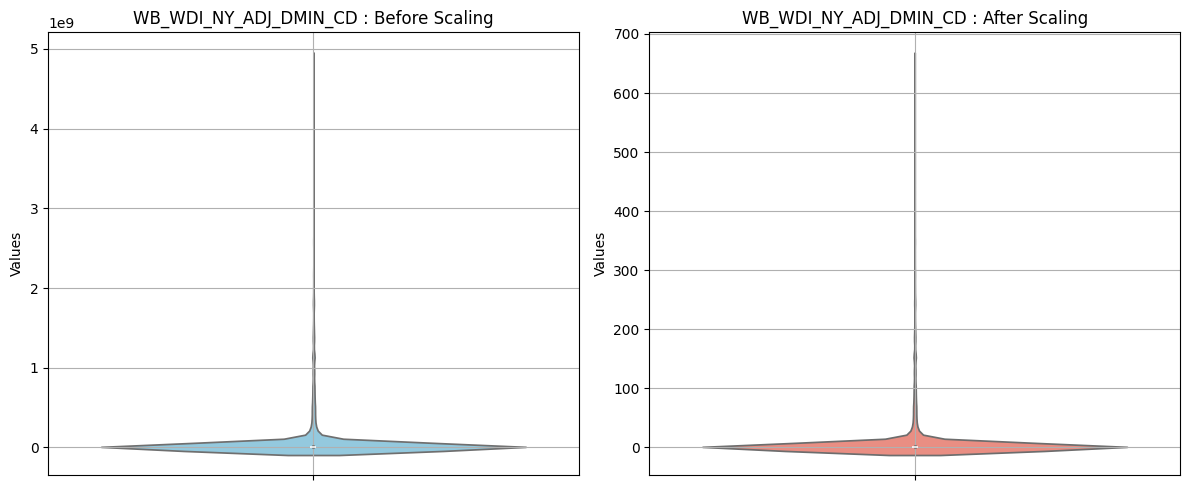

In [156]:
## affichage pour montrer qu'on garde la même distribution avec les outliers, mais en réduisant l'echelle
col = 'WB_WDI_NY_ADJ_DMIN_CD'  

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot avant scaling
sns.violinplot(y=train_interpolated[col], ax=ax1, color='skyblue')
ax1.set_title(f"{col} : Before Scaling")
ax1.set_ylabel("Values")
ax1.grid(True)

# Boxplot après scaling
sns.violinplot(y=train_scaled[col], ax=ax2, color='salmon')
ax2.set_title(f"{col} : After Scaling")
ax2.set_ylabel("Values")
ax2.grid(True)
plt.tight_layout()
plt.show()


## Partie création de rolling window (time series simplifiée)
- tsfresh à utiliser (rolling window - extract features)
- extract_feature avec le paramètre rolling_window : backward va permettre d'obtenir simplement des features (moy, max....)
- finalement extract_feature est beaucoup beaucoup trop lourd, on fait donc un traitement à la main

In [161]:
train_tot.shape

(5763, 170)

In [ ]:
'''#temp
# On part de train_scaled et test_scaled (après interpolation et scaling)
# On n'a pas encore séparé X et y

# On garde les colonnes sur lesquelles on veut calculer les features statistiques
cols_to_use = [c for c in train.columns if c not in ['REF_AREA','TIME_PERIOD','war_nextYear'] and "_was_interpolated" not in c]

## Sur train
# roll_time_series permet de créer des rolling window (sous séries) pour chaque pays
train_rolled = roll_time_series(
    train_scaled[['REF_AREA','TIME_PERIOD'] + cols_to_use],  # colonnes nécessaires, on remet ref_area et time_perdio pour les id et le tri
    column_id='REF_AREA',     
    column_sort='TIME_PERIOD',
    max_timeshift=3, # on prend au max 3 année précédentes
    min_timeshift=1 # et minimum 1 
)

# on calcul automatiquement avec extract_feature des features statistiques (mean, std,trend…) sur les rolling windows
train_features = extract_features(
    train_rolled,
    column_id='id',   # id créé par roll_time_series correspondant aux sous séries (pays,année)
    column_sort='time',
    default_fc_parameters=MinimalFCParameters()
)



## Test
test_rolled = roll_time_series(
    test_scaled[['REF_AREA','TIME_PERIOD'] + cols_to_use],
    column_id='REF_AREA',
    column_sort='TIME_PERIOD',
    max_timeshift=3,
    min_timeshift=1
)

test_features = extract_features(
    test_rolled,
    column_id='id',
    column_sort='time',
    default_fc_parameters=MinimalFCParameters()
)

#Fusion on garde les indicateurs de l'année t et on va ajouter les feature calculées par extract feature 
train_final = train_scaled[cols_to_use].merge(train_features, left_index=True, right_index=True)
# On vient remettre la colonne war_nextYear qu'on avait perdu dans le processus
train_final['war_nextYear'] = train_scaled['war_nextYear'].values

test_final = test_scaled[cols_to_use].merge(test_features, left_index=True, right_index=True)
test_final['war_nextYear'] = test_scaled['war_nextYear'].values
'''


In [162]:
train_scaled= train_scaled.drop("war",axis=1)
test_scaled= test_scaled.drop("war",axis=1)
train_tot_scaled = train_tot_scaled.drop("war",axis=1)
validation_scaled = validation_scaled.drop("war",axis=1)

train_scaledStandard= train_scaledStandard.drop("war",axis=1)
test_scaledStandard= test_scaledStandard.drop("war",axis=1)
train_tot_scaledStandard = train_tot_scaledStandard.drop("war",axis=1)
validation_scaledStandard=validation_scaledStandard.drop("war",axis=1)

In [81]:
def calcul_rolling_stats(df_input, cols_to_use):
    """
    Applique le rolling window et calcule les stats pour un dataframe donné
    """
    print(f"\n Traitement ")
    
    # Préparation pour tsfresh
    df_for_rolling = df_input[['REF_AREA', 'TIME_PERIOD'] + cols_to_use].copy()
    
    df_rolled = roll_time_series(
        df_for_rolling,
        column_id='REF_AREA',
        column_sort='TIME_PERIOD',
        max_timeshift=3,
        min_timeshift=1
    )
    
    # On enlève REF_AREA car l'id du pays est maintenant dans 'id' créé par tsfresh 
    df_rolled = df_rolled.drop('REF_AREA', axis=1)
    grouped = df_rolled.groupby('id')
    
    print(f"Calcul des stats")
    
    features_list = []
    for col in cols_to_use:
        series = grouped[col] # On récupère la série une seule fois par colonne
        
        features_list.extend([
            series.mean().rename(f'{col}_mean'),
            series.std().rename(f'{col}_std'),
            series.min().rename(f'{col}_min'),
            series.max().rename(f'{col}_max'),
            series.median().rename(f'{col}_median'),
            (series.max() - series.min()).rename(f'{col}_range'),
            series.quantile(0.25).rename(f'{col}_q25'),
            series.quantile(0.75).rename(f'{col}_q75')
        ])

    # Reconstruction du DataFrame
    df_features = pd.concat(features_list, axis=1)
    
    # on recupère REF_AREA et TIME_PERIOD depuis l'id (de tsfresh)
    df_features = df_features.reset_index()
    df_features['REF_AREA'] = df_features['id'].apply(lambda x: x[0])
    df_features['TIME_PERIOD'] = pd.to_datetime(df_features['id'].apply(lambda x: x[1]))
    
    # Merge avec les données d'origine
    df_final = df_input.merge(
        df_features.drop('id', axis=1),
        on=['REF_AREA', 'TIME_PERIOD'],
        how='left'
    )
    
    # Gestion des NaN (cas où aucune feature n'a pu être créées)
    n_nan = df_final.isna().any(axis=1).sum()
    if n_nan > 0:
        print(f"Lignes supprimées (NaN): {n_nan} ({n_nan/len(df_final):.1%})")
        
    return df_final.dropna()


#  fct principale
def createStatsFeatures(train_scaled, test_scaled):
    debut = time.time()
    
    
    cols_to_use = [
        c for c in train_scaled.columns 
        if c not in ['REF_AREA','TIME_PERIOD','war_nextYear'] 
        and "_was_interpolated" not in c
    ]
    print(f"Nombre de colonnes utilisées {len(cols_to_use)}")

    # Appel de la fonction pour Train
    train_final = calcul_rolling_stats(train_scaled, cols_to_use)

    # Appel de la fonction pour Test
    test_final = calcul_rolling_stats(test_scaled, cols_to_use)

    fin = time.time()
    print(f"FIN")
    print(f"Temps d'exec: {(fin-debut):.2f} s")
    print(f"Shape Train: {train_final.shape}")
    print(f"Shape Test : {test_final.shape}")
    
    return train_final, test_final

In [ ]:
train_tot_final, test_final = createStatsFeatures(train_tot_scaled,test_scaled)
train_final, validation_final = createStatsFeatures(train_scaled,validation_scaled)

In [ ]:
train_tot_finalStandard, test_finalStandard = createStatsFeatures(train_tot_scaledStandard,test_scaledStandard)
train_finalStandard, validation_finalStandard = createStatsFeatures(train_scaledStandard,validation_scaledStandard)

## Séparation en X / y

In [165]:
# Séparer X / y - Robust

X_train = train_final.drop(['war_nextYear', 'REF_AREA', 'TIME_PERIOD'], axis=1)
y_train = train_final['war_nextYear']

X_validation = validation_final.drop(['war_nextYear', 'REF_AREA', 'TIME_PERIOD'], axis=1)
y_validation = validation_final['war_nextYear']


X_train_tot = train_tot_final.drop(['war_nextYear', 'REF_AREA', 'TIME_PERIOD'], axis=1)
y_train_tot = train_tot_final['war_nextYear']

X_test = test_final.drop(['war_nextYear', 'REF_AREA', 'TIME_PERIOD'], axis=1)
y_test = test_final['war_nextYear']



print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (4520, 830)
y_train shape: (4520,)


In [166]:
# Séparer X / y - StandardScaler
X_trainStandard = train_finalStandard.drop(['war_nextYear', 'REF_AREA', 'TIME_PERIOD'], axis=1)
y_trainStandard = train_finalStandard['war_nextYear']

X_validationStandard = validation_finalStandard.drop(['war_nextYear', 'REF_AREA', 'TIME_PERIOD'], axis=1)
y_validationStandard = validation_finalStandard['war_nextYear']


X_trainStandard_tot = train_tot_finalStandard.drop(['war_nextYear', 'REF_AREA', 'TIME_PERIOD'], axis=1)
y_trainStandard_tot = train_tot_finalStandard['war_nextYear']

X_testStandard = test_finalStandard.drop(['war_nextYear', 'REF_AREA', 'TIME_PERIOD'], axis=1)
y_testStandard = test_finalStandard['war_nextYear']

print(f"X_train shape: {X_trainStandard.shape}")
print(f"y_train shape: {y_trainStandard.shape}")

X_train shape: (4520, 830)
y_train shape: (4520,)


## PCA + suppression des flags - on applique la PCA uniquement sur les dataset scalé avec le standardScaler 

In [167]:

def applyPCA(X_train, X_test, cols_to_drop, n_components=0.95):
    """
    Applique la PCA, visualise les résultats et renvoie les données transformées.
    
    Args:
        n_components: float (0.95) pour garder 95% de variance, ou int (ex: 5) pour fixer le nombre.
    """
    print("DEBUT PCA")
    
    # 1. Nettoyage : On retire les colonnes techniques 
    X_train_clean = X_train.drop(columns=cols_to_drop)
    X_test_clean = X_test.drop(columns=cols_to_drop)

    # 2. Calcul PCA
    pca = PCA(n_components=n_components, random_state=42)
    
    X_train_pca = pca.fit_transform(X_train_clean)
    X_test_pca = pca.transform(X_test_clean)
    
    # 3. Création des DataFrames propres (On garde l'INDEX d'origine)
    pca_cols = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]
    
    df_train_pca = pd.DataFrame(X_train_pca, columns=pca_cols, index=X_train.index)
    df_test_pca = pd.DataFrame(X_test_pca, columns=pca_cols, index=X_test.index)

    print(f"Dimensions originales : {X_train_clean.shape}")
    print(f"Dimensions PCA        : {df_train_pca.shape} (pour {n_components*100}% de variance)")
    print(f"Variance expliquée    : {pca.explained_variance_ratio_.sum():.4f}")

    # visualisation
    
    # A. Variance Cumulée
    plt.figure(figsize=(10, 4))
    cumulative_variance = pca.explained_variance_ratio_.cumsum()
    plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
    plt.axhline(y=0.95, color='r', linestyle='-', alpha=0.5, label='95% Seuil')
    plt.title('PCA - Variance Expliquée Cumulée')
    plt.xlabel('Nombre de Composantes')
    plt.ylabel('Variance')
    plt.grid(True)
    plt.legend()
    plt.show()

    # On regarde les loadings (poids) des variables sur les composantes
    loadings = pd.DataFrame(
        pca.components_.T,
        index=X_train_clean.columns,
        columns=pca_cols
    )
    
    # On sélectionne les 20 variables qui pèsent le plus lourd au total
    top_vars = loadings.abs().sum(axis=1).sort_values(ascending=False).head(20).index
    
    # On affiche la Heatmap limité aux 5 premières PC 
    cols_to_show = pca_cols[:10] if len(pca_cols) > 10 else pca_cols
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(loadings.loc[top_vars, cols_to_show], cmap="coolwarm", center=0)
    plt.title("PCA - Top 20 Variables contribuantes (Loadings)")
    plt.show()

    return df_train_pca, df_test_pca, pca


# colonnes à exclure
cols_not_pca = [c for c in train_interpolated.columns if "_was_interpolated" in c]



DEBUT PCA
Dimensions originales : (5650, 747)
Dimensions PCA        : (5650, 16) (pour 95.0% de variance)
Variance expliquée    : 0.9527


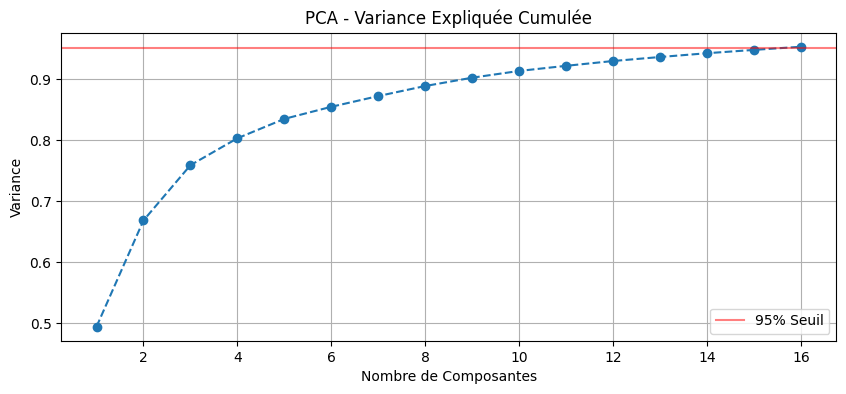

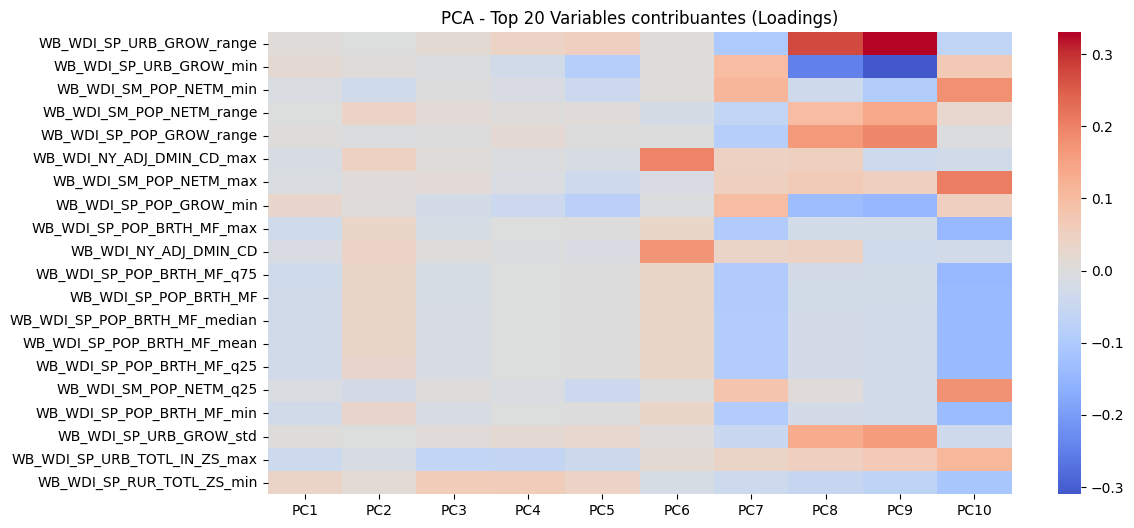

In [168]:

X_train_tot_pca, X_test_pca, pca_model = applyPCA(
    X_trainStandard_tot, 
    X_testStandard, 
    cols_to_drop=cols_not_pca,
    n_components=0.95
)

DEBUT PCA
Dimensions originales : (4520, 747)
Dimensions PCA        : (4520, 6) (pour 99.9% de variance)
Variance expliquée    : 0.9992


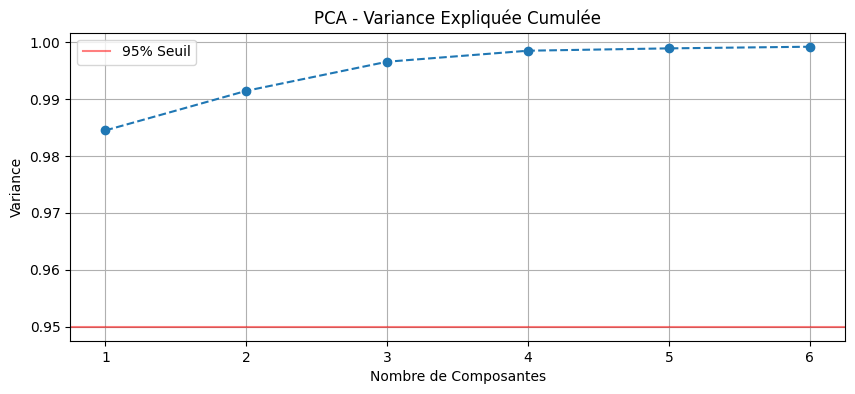

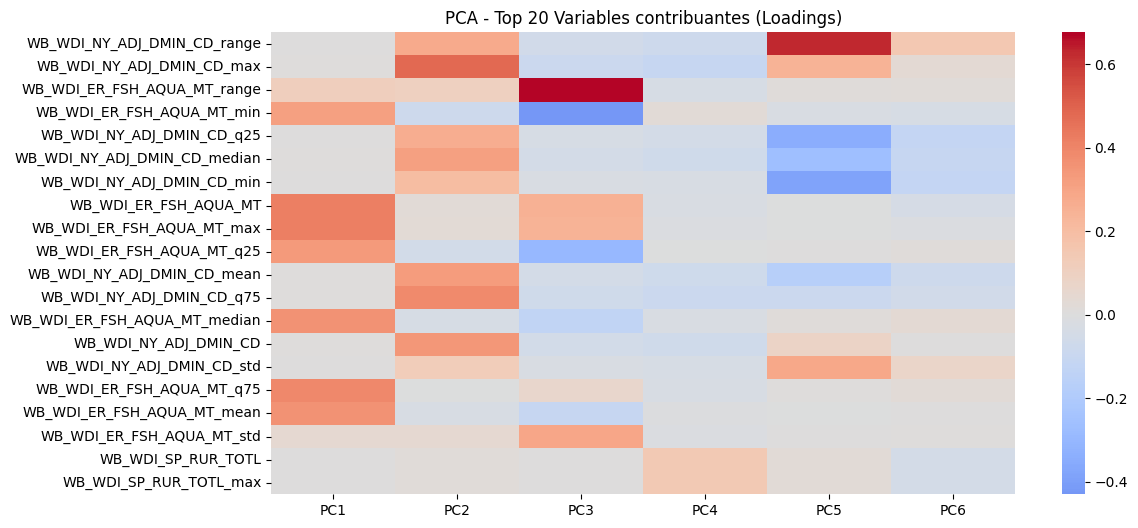

In [171]:
# avec 95 % de variance expliquée, on a une seule composante principale, on augmente donc un peu pour avoir un peu plus d'information

X_train_pca, X_validation_pca, pca_model = applyPCA(
    X_trainStandard, 
    X_validationStandard, 
    cols_to_drop=cols_not_pca,
    n_components=0.999
) 

# Résumé 
- j'ai maintenant : X_train_tot_pca et X_test_pca (et X_train_pca et X_validation_pca pour avoir une étape de validation) correspondant à des dataframe avec comme features les composantes principales déduite avec PCA -> surement inéficace pour random forest, boost..
- on a aussi toujours X_train_tot/y_train_tot, X_test/y_test avec uniquement les indicateurs + flags + lags (mean, min, max, std...) - et X_train/y_train, X_validation/y_validation

### Appliquer la PCA sur des donnée pas scalé également n'est pas bon, ici on utilise un Robust Scaler (bon pour Xgboost etc avec des données socio-économiques) - Solution un deuxième traitement où à la place du RobustScaler on scale avec un Standard Scaler pour appliquer la PCA

## On va maintenant visualiser la répartition des feature expliquant toute la variance (PC1, PC2 pour l'instant)

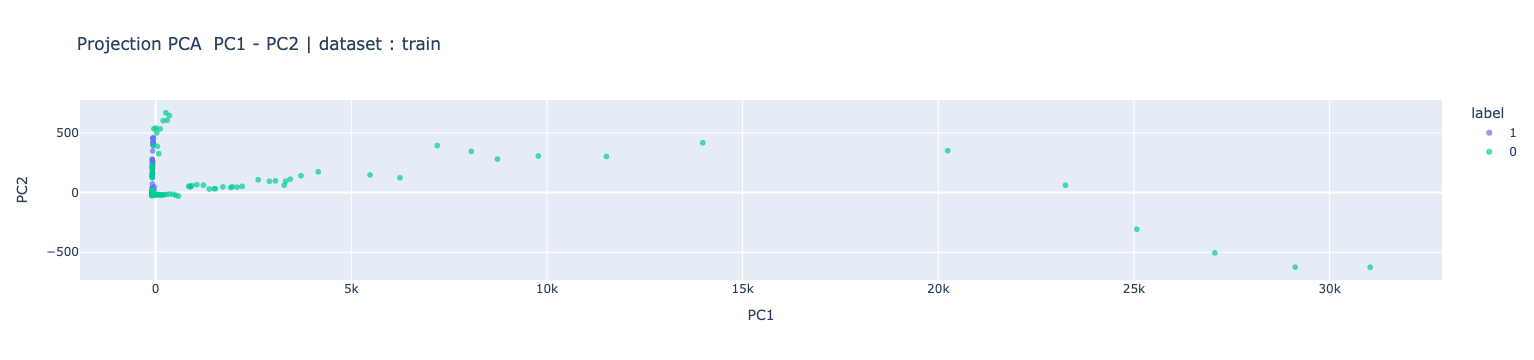

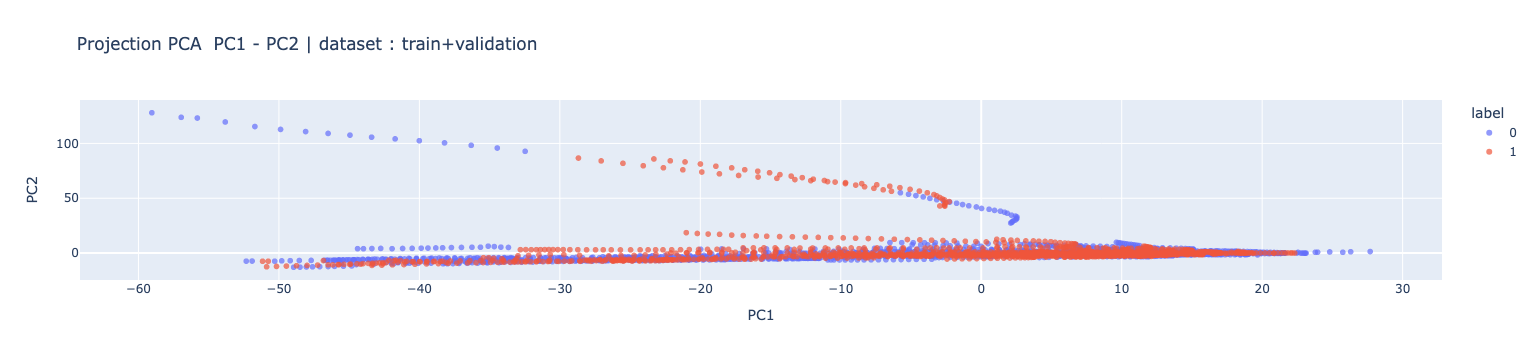

In [174]:
X_plot = X_train_pca.copy()
X_plot["label"] = y_validationStandard.astype(str)


fig = px.scatter(
    X_plot,
    x="PC1",
    y="PC2",
    color="label",
    title="Projection PCA  PC1 - PC2 | dataset : train",
    opacity=0.7
)
fig.show()

X_plot_tot = X_train_tot_pca.copy()
X_plot_tot["label"] = y_trainStandard.astype(str)


fig = px.scatter(
    X_plot_tot,
    x="PC1",
    y="PC2",
    color="label",
    title="Projection PCA  PC1 - PC2 | dataset : train+validation",
    opacity=0.7
)
fig.show()


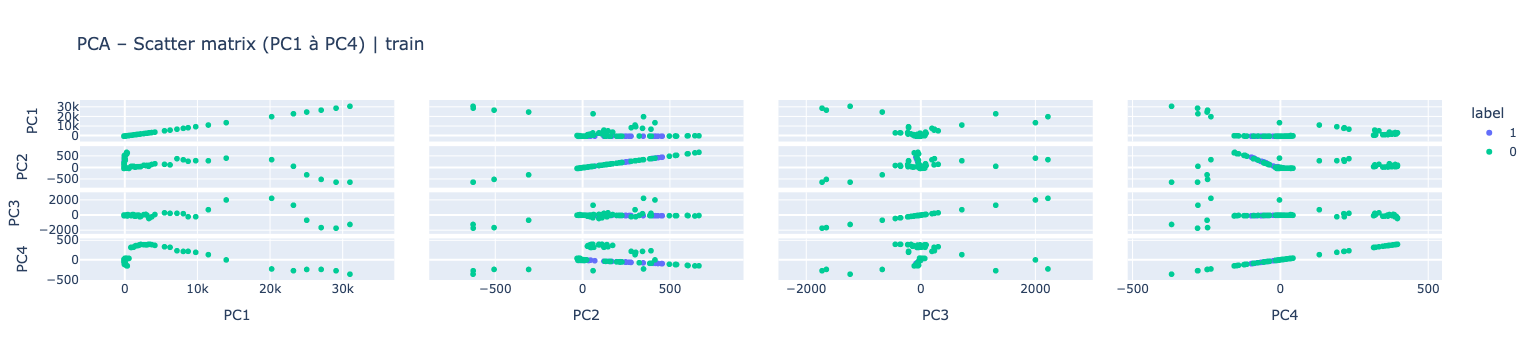

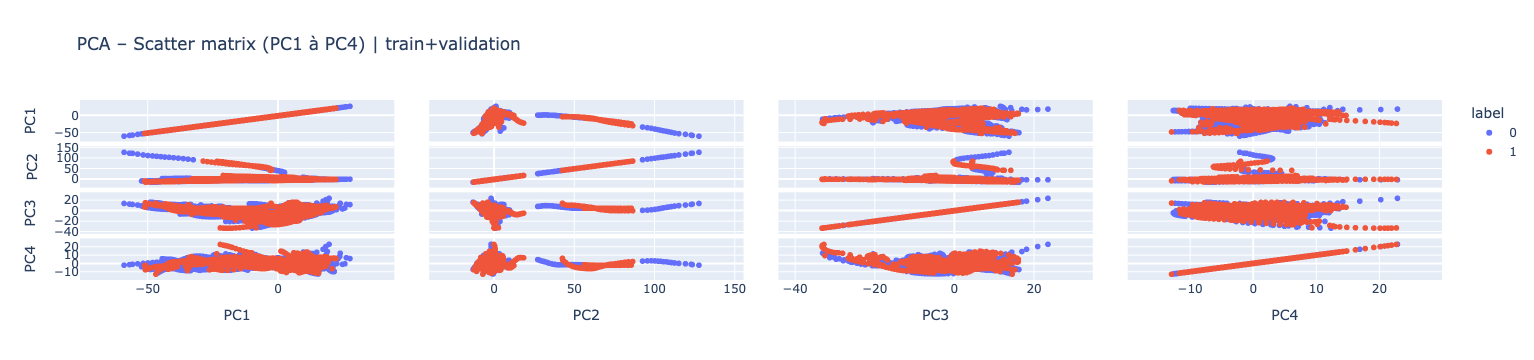

In [176]:
fig = px.scatter_matrix(
    X_plot,
    dimensions=["PC1", "PC2", "PC3", "PC4"],
    color="label",
    title="PCA – Scatter matrix (PC1 à PC4) | train"
)
fig.show()

fig = px.scatter_matrix(
    X_plot_tot,
    dimensions=["PC1", "PC2", "PC3", "PC4"],
    color="label",
    title="PCA – Scatter matrix (PC1 à PC4) | train+validation"
)
fig.show()

## Train  + evaluation
- Rappel des variables :
    - X_train/y_train - X_validation/y_validation
    - X_train_tot/y_train_tot - X_test/y_test
    - X_train_tot_pca/y_train_tot - X_test_pca/y_test
    -  X_train_pca/y_train - X_validation_pca/y_validation

In [182]:
def train_and_evaluate(X_train, y_train, X_val, y_val, model, model_name):
    """
    Entraine un modèle sur un jeu de train et évalue sur un jeu de validation.
    
    params:
        X_train, y_train: données d'entraînement
        X_val, y_val: données de validation / test
        model: modèle (XGBoost, CatBoost, SVM, etc...)
        model_name: str, nom du modèle pour affichage
    Returns:
        dictionnaire de metrics
    """
    print(f"\n #### {model_name} ###")
    
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédiction
    y_pred_val = model.predict(X_val)
    y_pred_train = model.predict(X_train)
    
    # Calcul métriques
    metrics = {
        "accuracy": accuracy_score(y_val, y_pred_val),
        "precision": precision_score(y_val, y_pred_val, zero_division=0),
        "recall": recall_score(y_val, y_pred_val, zero_division=0),
        "f1": f1_score(y_val, y_pred_val, zero_division=0),
        "f1_train": f1_score(y_train, y_pred_train, zero_division=0)
    }
    
    # Affichage
    for k, v in metrics.items():
        print(f"{k:<12}: {v:.4f}")
    print(f"Overfitting (F1 train - F1 val): {metrics['f1_train'] - metrics['f1']:.4f}")
    
    return metrics

In [181]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

metrics_xgb = train_and_evaluate(X_train, y_train, X_validation, y_validation, xgb_model, model_name="XGBoost")



 XGBoost 
accuracy    : 0.7633
precision   : 0.7411
recall      : 0.6957
f1          : 0.7177
f1_train    : 1.0000
Overfitting (F1 train - F1 val): 0.2823


In [184]:
MLP_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=42,
    early_stopping=True,
    learning_rate='adaptive'
)

metrics_mlp = train_and_evaluate(X_train_pca, y_train, X_validation_pca, y_validation, MLP_model, model_name="Multi Layer Perceptron")





 #### Multi Layer Perceptron ###
accuracy    : 0.7268
precision   : 0.6935
recall      : 0.6598
f1          : 0.6763
f1_train    : 0.6872
Overfitting (F1 train - F1 val): 0.0109


In [185]:
catboost_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="F1",
    random_seed=42,
    verbose=False
)

metrics_catboost = train_and_evaluate(X_train, y_train, X_validation, y_validation, catboost_model, model_name="Catboost")


 #### Catboost ###
accuracy    : 0.7777
precision   : 0.7746
recall      : 0.6854
f1          : 0.7273
f1_train    : 0.9906
Overfitting (F1 train - F1 val): 0.2633


In [195]:
svm_model = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    class_weight="balanced",  
    random_state=42
)

metrics_svm = train_and_evaluate(X_train_pca, y_train, X_validation_pca, y_validation,svm_model,model_name="SVM")


 #### SVM ###
accuracy    : 0.6361
precision   : 0.6722
recall      : 0.3095
f1          : 0.4238
f1_train    : 0.3080
Overfitting (F1 train - F1 val): -0.1158


In [192]:
# création d'un dataframe récapitulatif

results = []

results.append({"model": "XGBoost", **metrics_xgb})
results.append({"model": "CatBoost", **metrics_catboost})
results.append({"model": "MLP", **metrics_mlp})
results.append({"model": "SVM", **metrics_svm})

df_results = pd.DataFrame(results)
df_results["f1_gap_train_val"] = df_results["f1_train"] - df_results["f1"]
df_results.sort_values(by="f1", ascending=False)

df_results

,model,accuracy,precision,recall,f1,f1_train,f1_gap_train_val
0,XGBoost,0.763274,0.741144,0.695652,0.717678,1.000000,0.282322
1,CatBoost,0.777655,0.774566,0.685422,0.727273,0.990579,0.263306
2,MLP,0.726770,0.693548,0.659847,0.676278,0.687167,0.010890
3,SVM,0.636062,0.672222,0.309463,0.423818,0.308020,-0.115797
